In [1]:
import numpy as np

import adaptive_latents
from adaptive_latents import AnimationManager, Pipeline, CenteringTransformer, proSVD, Bubblewrap, VanillaOnlineRegressor, NumpyTimedDataSource, KernelSmoother, Concatenator, sjPCA
import adaptive_latents.input_sources.datasets as datasets
import adaptive_latents.plotting_functions as pf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import Video, Image, display


In [2]:
!hostname

tycho



## Combination and prediction video


A newer version (0.63.1) of dandi/dandi-cli is available. You are using 0.63.0
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.4.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/jgould/miniconda3/envs/adaptive_latents/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


  0%|          | 0/154.9 [00:00<?, ?it/s]

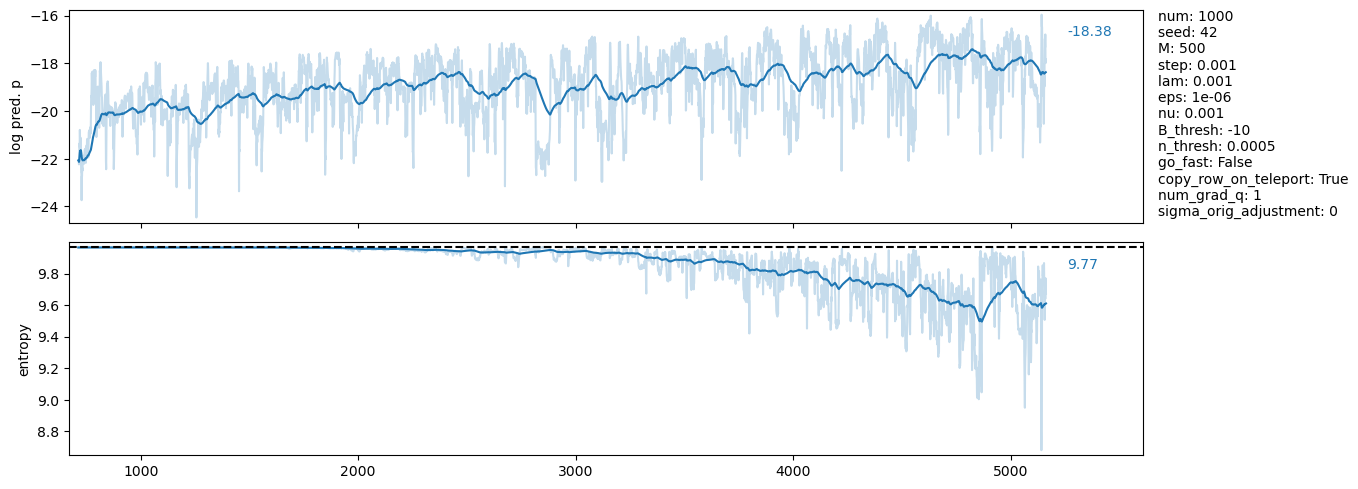

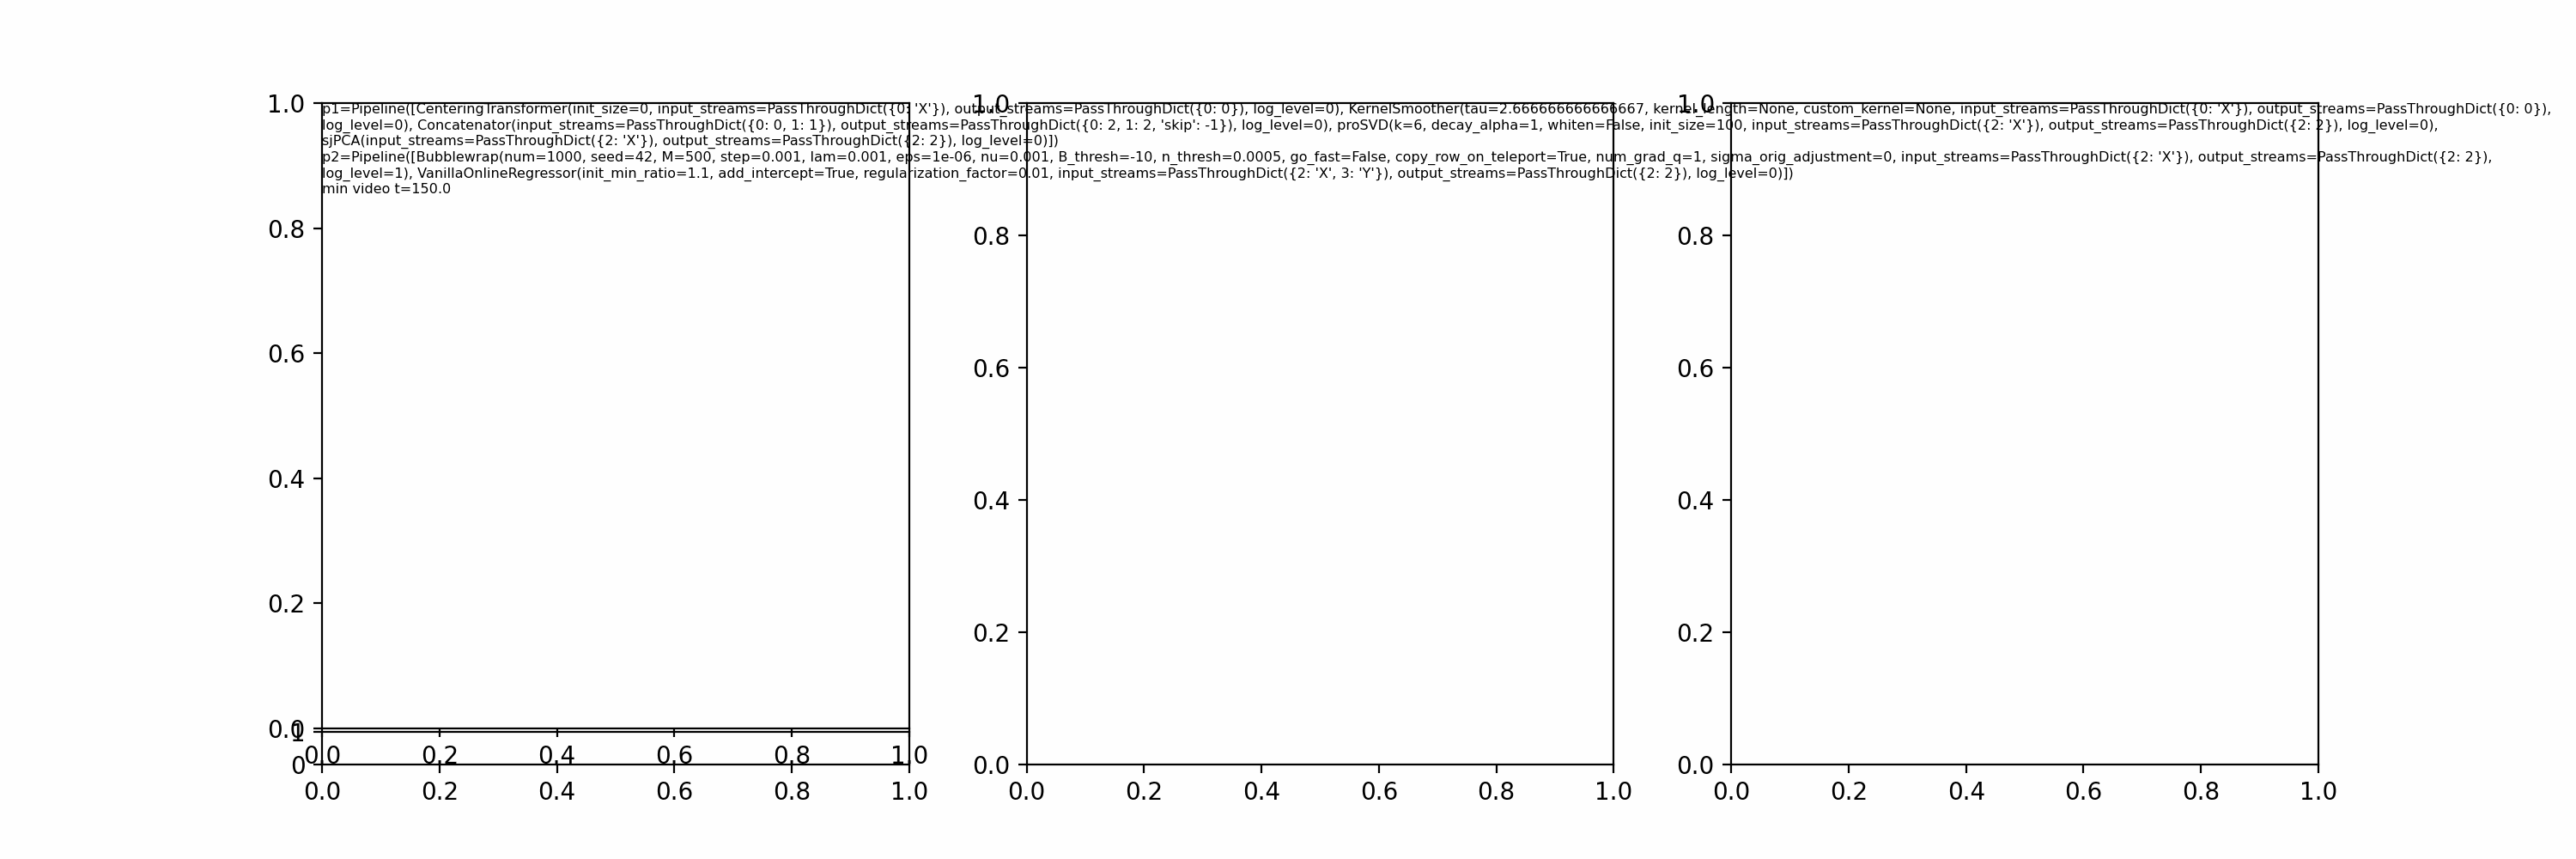

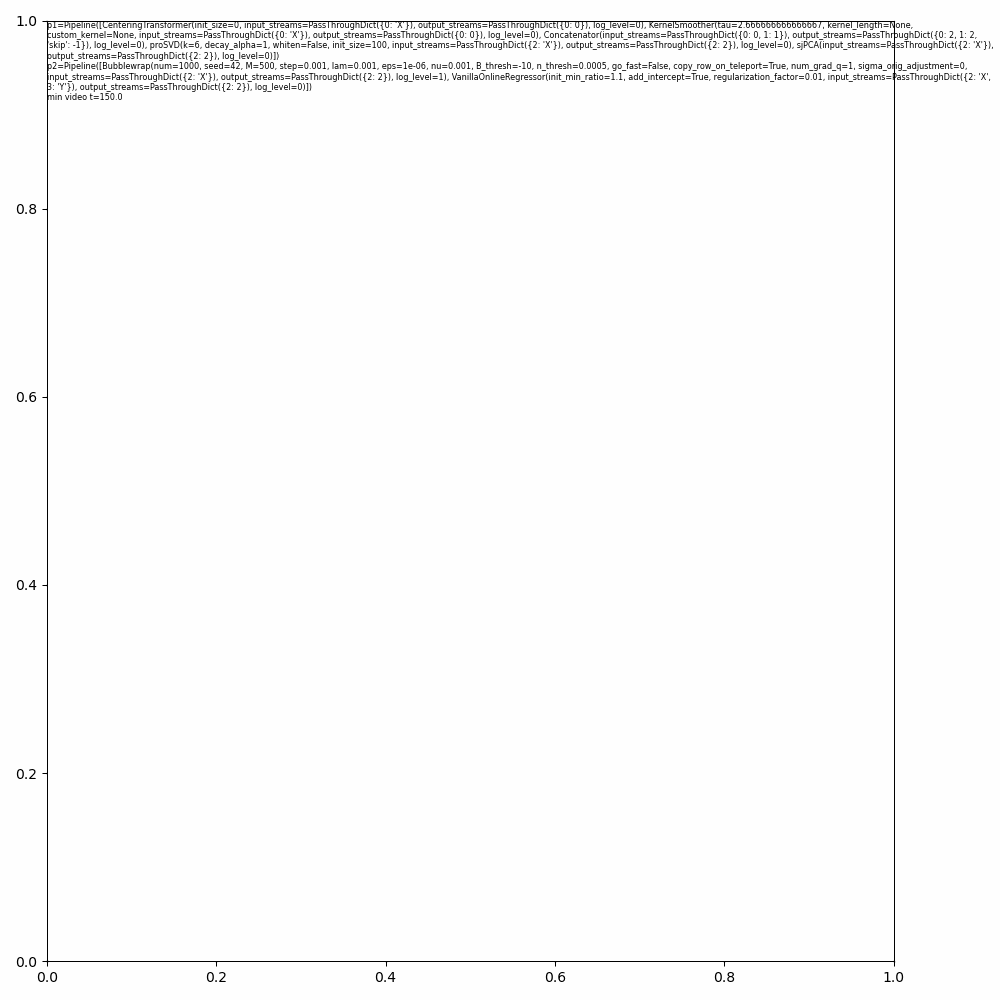

CPU times: user 3min 30s, sys: 32.2 s, total: 4min 3s
Wall time: 3min 44s


Text(0.5, 1.0, 'alpha')

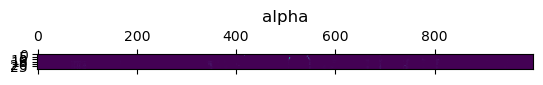

In [3]:
%%time
%matplotlib inline
d = datasets.Odoherty21Dataset()

streams = []
streams.append( (d.neural_data,     0) )
streams.append( (d.behavioral_data, 1) )
streams.append( (d.behavioral_data, 3) )

p1 = Pipeline([
    CenteringTransformer(init_size=0, input_streams={0:'X'}, output_streams={0:0}),
    # CenteringTransformer(init_size=0, input_streams={1:'X'}, output_streams={1:1}),
    KernelSmoother(tau=0.08/d.bin_width, input_streams={0:'X'}, output_streams={0:0}),
    Concatenator(input_streams={0: 0, 1: 1}, output_streams={0:2, 1:2, 'skip':-1}),
    pro:=proSVD(k=6, init_size=100, input_streams={2:'X'}, output_streams={2:2}),
    sjPCA(init_size=100, input_streams={2:'X'}, output_streams={2:2}),
])

p2 = Pipeline([
    bw:=Bubblewrap(
        num=1000,
        M=500,
        eps=1e-6,
        step=1e-3,
        num_grad_q=1,
        input_streams={2:'X'},
        output_streams={2:2},
        log_level=1,
    ),
    reg:=VanillaOnlineRegressor(
        input_streams={2:'X', 3:'Y'},
        output_streams={2:2},
    ),
])



video_dt = 0.1
video_ts = np.arange(50)*video_dt + 150
streams.append( (NumpyTimedDataSource(np.nan * video_ts, video_ts), 'video') )


pbar = tqdm(total=video_ts[-1])
latents = []
latent_ts = []

latent_predictions = []
beh_predictions = []
prediction_ts = []

pred_am = None
bw_am = None
with (
    plt.ioff(),
    AnimationManager(fps=1/video_dt, filetype='gif') as bw_am, 
    (vid:=pf.PredictionVideo(d, fps=1/video_dt, filetype='gif')).am as pred_am
):
    for output, stream in Pipeline().streaming_run_on(streams, return_output_stream=True):
        # dim reduction part of pipeline
        output, stream = p1.partial_fit_transform(output, stream, return_output_stream=True)
        if stream == 2 and np.isfinite(output).all():
            latents.append(output)
            latent_ts.append(output.t)

        # prediction part of pipeline
        output, stream = p2.partial_fit_transform(output, stream, return_output_stream=True)
        if stream == 2 and np.isfinite(output).all():
            prediction_t = output.t+bw.dt*1
            alpha_pred = bw.get_alpha_at_t(0, relative_t=True)
            latent_prediction = np.array(bw.mu[np.argmax(alpha_pred)])
            beh_prediction = reg.predict(alpha_pred)

            latent_predictions.append(latent_prediction)
            beh_predictions.append(beh_prediction)
            prediction_ts.append(prediction_t)
            
        
        if stream == 'video':
            
            if bw_am is not None:
                if output.t == video_ts[0]:
                    ax: plt.Axes = bw_am.axs[0,0]
                    ax.text(0,1, f"p1={str(p1)}\np2={str(p2)}\nmin video t={video_ts.min()}", transform=ax.transAxes, fontsize='xx-small', verticalalignment='top', wrap=True)
                    bw_am.grab_frame()
                    
                ax: plt.Axes = bw_am.axs[0,0]
                ax.cla()
                bw.scatter_data_with_decay(ax,np.squeeze(latents))
                bw.show_active_bubbles_and_connections_2d(ax, np.squeeze(latents))
                bw_am.grab_frame()
                
            if pred_am is not None:
                if output.t == video_ts[0]:
                    ax = vid.neural_data_ax
                    ax.text(0,1, f"p1={str(p1)}\np2={str(p2)}\nmin video t={video_ts.min()}", transform=ax.transAxes, fontsize='xx-small', verticalalignment='top', wrap=True)
                    ax.set_zorder(1)
                    pred_am.grab_frame()
                
                vid.plot_for_video_t(output.t, latents, latent_ts, latent_predictions, beh_predictions, prediction_ts)
            
            if output.t == video_ts[-1]:
                break

        pbar.update(round(output.t,1) - pbar.n)


latents = np.squeeze(latents)
latent_predictions = np.squeeze(latent_predictions)
beh_predictions = np.squeeze(beh_predictions)
prediction_ts = np.squeeze(prediction_ts)

plt.close()
plt.close()

Bubblewrap.compare_runs([bw], t_in_samples=True)
plt.show()

if pred_am is not None:
    display_class = Image if 'gif' in str(pred_am.outfile) else Video
    display(display_class(pred_am.outfile, embed=True, width=900))


if bw_am is not None:
    display_class = Image if 'gif' in str(bw_am.outfile) else Video
    display(display_class(bw_am.outfile, embed=True, width=700))

fig, ax = plt.subplots()
ax.matshow(bw.log['alpha'][-30:])
ax.set_title('alpha')

In [4]:
estimates = adaptive_latents.utils.resample_matched_timeseries(d.behavioral_data.a[:,0,:],d.behavioral_data.t,  prediction_ts)
targets = beh_predictions

errors = estimates - targets
test_s = prediction_ts > (prediction_ts[0] + prediction_ts[-1] )/2

print([np.corrcoef(estimates[test_s,i], targets[test_s,i])[0,1] for i in range(3)])

[np.float64(0.9215061294044771), np.float64(0.9537419231277955), np.float64(0.6566758763967865)]


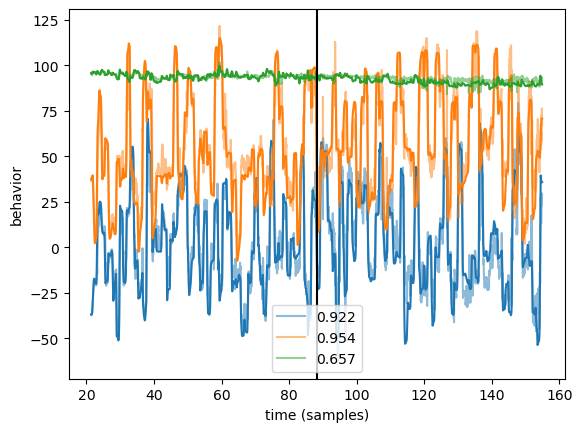

In [14]:
for i in range(3):
    plt.plot(prediction_ts, estimates[:,i], color=f'C{i}')
    plt.plot(prediction_ts, targets[:,i], color=f'C{i}', alpha=.5, label=f'{np.corrcoef(estimates[test_s,i], targets[test_s,i])[0,1]:.3f}')
plt.axvline(prediction_ts[test_s].min(), color='k')
plt.xlabel("time (samples)")
plt.ylabel("behavior")
plt.legend()

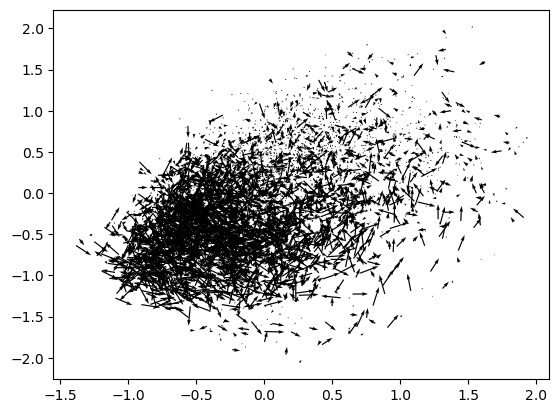

In [6]:

%matplotlib inline
fig, ax = plt.subplots()
s = np.array(latent_ts) > 10
# ax.scatter(latents[s,0], latents[s,1], s=5, alpha=.1, c='C0', edgecolors='none')
sub_latents = latents[s]
d_sub_latents = np.diff(sub_latents, axis=0)
d_sub_latents = d_sub_latents / np.linalg.norm(d_sub_latents, axis=1)[:, np.newaxis]

ax.quiver(sub_latents[:-1,0], sub_latents[:-1,1], d_sub_latents[:,0], d_sub_latents[:,1], scale=1/20, units='dots')

x1, x2, y1, y2 = ax.axis()

x_points = np.linspace(x1, x2, 10)
y_points = np.linspace(y1, y2, 10)
mgrid = np.meshgrid(*[np.linspace(sub_latents[:,i].min(),sub_latents[:,i].max(), 10) for i in range(sub_latents.shape[1])])

# arrows = np.zeros(shape=(len(points), sub_latents.shape[1]))

# ax.quiver(points[:,0], points[:,1])


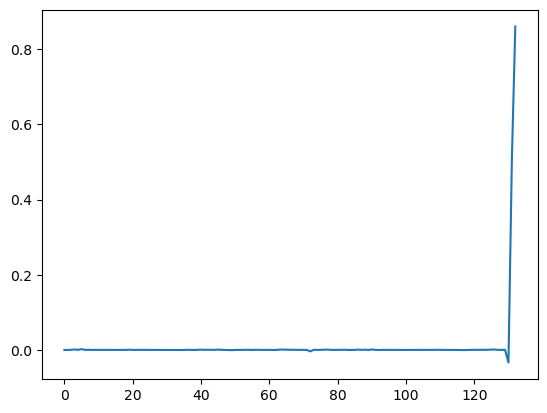

In [7]:
plt.plot(pro.Q[:,0])

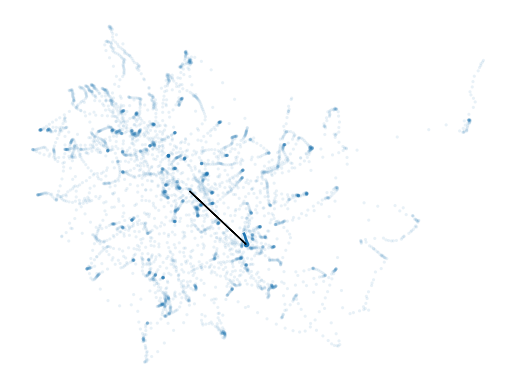

In [8]:

fig, ax = plt.subplots()

dim_1, dim_2 = 2,3
pf.plot_history_with_tail(ax, latents, dim_1=dim_1, dim_2=dim_2)
means = np.mean(latents, axis=0)

ax.arrow(latents[-1,dim_1], latents[-1,dim_2], means[dim_1] - latents[-1,dim_1], means[dim_2] - latents[-1,dim_2], zorder=5, head_width=.1, color='k')

ax.axis('off');



In [9]:
pro.Q[:,0]

array([ 3.54618144e-05, -2.43527013e-04,  3.39765892e-04,  1.26069428e-03,
        1.24325059e-04,  2.21112283e-03,  2.03599375e-05,  3.97507145e-04,
       -3.82323901e-06,  1.18036041e-04,  1.26365965e-04,  1.39663294e-05,
        1.01775036e-04,  1.43757401e-04,  2.35335065e-04, -1.44503050e-05,
       -7.83355930e-05,  1.70497318e-05,  2.14495086e-05,  6.32691419e-04,
        2.56446107e-05,  9.57932974e-05,  9.55795378e-05,  1.71086189e-04,
        7.92511658e-06,  1.66394793e-05, -1.50863115e-05,  1.37285261e-04,
       -3.31552203e-06,  3.94338676e-06,  8.91722316e-05,  6.84559413e-05,
        6.41653064e-05,  4.83017033e-05,  1.75954505e-05, -2.37557266e-04,
        3.02151123e-04,  9.44123655e-05, -1.30126539e-04,  1.65336298e-04,
        7.72638023e-04,  4.28746388e-05,  4.66985819e-04,  2.64050563e-04,
        7.61300061e-05,  9.60701998e-04,  2.03215028e-04, -4.56613066e-05,
       -1.07509696e-04, -5.85349504e-04,  4.22411759e-05, -1.12429704e-04,
        1.12478340e-05,  

In [10]:
assert isinstance(d, datasets.Zong22Dataset)
desired_pattern = np.mean(latents[-101:-1], axis=0)
current_pattern = latents[-1]
desired_stim = desired_pattern - current_pattern

desired_pattern = (desired_stim @ pro.Q.T)[:d.neural_data.a.shape[-1]]

near_zero = np.abs(desired_stim) < 100
print(near_zero.sum())
desired_stim[near_zero] = np.nan


fig, ax = plt.subplots()
d.show_stim_pattern(ax, np.abs(desired_pattern))


AssertionError: 

## Intro video

In [ ]:
d = datasets.Odoherty21Dataset()

tail_length = 5  # seconds

with AnimationManager(n_cols=2, n_rows=1, figsize=(10, 5)) as am:
    for current_t in np.linspace(100, 110, 51):
        am.axs[0,0].cla()

        n_columns = np.floor(tail_length / d.bin_width).astype(int)
        idx = np.nonzero(~(d.neural_data.t < current_t))[0][0]
        
        
        am.axs[0,0].imshow(d.neural_data.a[idx-n_columns:idx,0,:].T, aspect='auto', interpolation='none', extent=[current_t - tail_length, current_t, d.neural_data.a.shape[2], 0])



        old_lims = am.axs[0,1].axis()
        am.axs[0,1].cla()
        am.axs[0,1].axis('off')
        
        s = ((current_t - tail_length) < d.behavioral_data.t) & (d.behavioral_data.t < current_t)
        am.axs[0,1].plot(d.behavioral_data.a[s,0,0], d.behavioral_data.a[s,0,1])
        pf.use_bigger_lims(am.axs[0,1], old_lims)
        
        am.grab_frame()